# 1. Цель лабораторной работы

Изучить ансамбли моделей машинного обучения.

# 2. Задание

1.	Выберите набор данных (датасет) для решения задачи классификации или регресии.
2.	В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.	С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4.	Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.
5.	Произведите для каждой модели подбор значений одного гиперпараметра. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.
6.	Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.


# 3. Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков:

In [0]:
from google.colab import files

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [2]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving covid19-russia-cases.csv to covid19-russia-cases (1).csv
User uploaded file "covid19-russia-cases.csv" with length 281785 bytes


## Предварительная подготовка данных

Датасет - COVID-19 Russia regions cases. COVID-19 virus (coronavirus) has been starting to spread inside of Russia. This is important to investigate and understand the spreading from a very low level. The world-level data is representing Russia virus cases as a single point. But Russia is a very huge and heterogeneous country. For better analyze we have to consider Russia infection cases distributed by region. So this is a dataset of regions distributed COVID-19 virus inside of Russia.

In [0]:
data = pd.read_csv("covid19-russia-cases.csv", delimiter=';')

Уберем столбец с названиями и реобразуем дату в соответствующий временной формат:

In [0]:
df = data.copy()

df["Date"] = pd.to_datetime(df["Date"]).astype(np.int64)/1000000

df = df.drop(["Region/City-Eng"], axis=1)

df["Region_ID"] =df["Region_ID"].fillna(method='ffill')

df=df.dropna()

Верхушка данных и типы

In [37]:
df.head()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
1,1.580429e+12,72.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.580429e+12,75.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.606867e+12,72.0,0.0,0.0,1.0,1.0,0.0,1.0
4,1.606867e+12,75.0,0.0,0.0,1.0,1.0,0.0,1.0
5,1.583107e+12,50.0,1.0,0.0,0.0,1.0,0.0,0.0


In [38]:
df.dtypes

Date             float64
Region_ID        float64
Day-Confirmed    float64
Day-Deaths       float64
Day-Recovered    float64
Confirmed        float64
Deaths           float64
Recovered        float64
dtype: object

In [39]:
df.isnull().sum()

Date             0
Region_ID        0
Day-Confirmed    0
Day-Deaths       0
Day-Recovered    0
Confirmed        0
Deaths           0
Recovered        0
dtype: int64

Проверим основные статистические характеристики набора данных:

In [40]:
df.describe()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
count,4.498000e+03,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000
mean,1.590025e+12,44.236105,80.616052,0.848155,29.179191,1654.563139,15.745220,352.179858
std,6.111935e+09,25.034676,393.074041,5.128834,214.880010,9997.870475,108.936064,2274.627093
min,1.578096e+12,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.587082e+12,23.000000,5.000000,0.000000,0.000000,57.000000,0.000000,7.000000
50%,1.588637e+12,44.000000,23.000000,0.000000,3.000000,309.500000,3.000000,46.000000
75%,1.590365e+12,65.000000,54.000000,0.000000,18.000000,966.000000,8.000000,243.000000
max,1.607126e+12,95.000000,6703.000000,77.000000,8033.000000,169303.000000,2110.000000,61619.000000


## Разделение данных

In [0]:
X = df.drop("Deaths", axis=1)
y = df["Deaths"]

In [42]:
print(X.head(), "\n")
print(y.unique()[1:20])

           Date  Region_ID  Day-Confirmed  ...  Day-Recovered  Confirmed  Recovered
1  1.580429e+12       72.0            1.0  ...            0.0        1.0        0.0
2  1.580429e+12       75.0            1.0  ...            0.0        1.0        0.0
3  1.606867e+12       72.0            0.0  ...            1.0        1.0        1.0
4  1.606867e+12       75.0            0.0  ...            1.0        1.0        1.0
5  1.583107e+12       50.0            1.0  ...            0.0        1.0        0.0

[5 rows x 7 columns] 

[ 2.  3.  8.  1. 11. 16. 19. 20. 27. 29. 31. 10. 38. 13.  4. 50. 58. 14.
 72.]


In [43]:
print(X.shape)
print(y.shape)

(4498, 7)
(4498,)


Предобработаем данные, чтобы методы работали лучше:

In [44]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Recovered
count,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03
mean,-1.691459e-14,-1.419743e-16,1.330022e-16,3.543828e-15,-4.230350e-16,5.504218e-17,-2.970365e-16
std,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00
min,-1.951890e+00,-1.727241e+00,-2.051141e-01,-1.653883e-01,-1.358080e-01,-1.654099e-01,-1.548469e-01
25%,-4.815543e-01,-8.483619e-01,-1.923924e-01,-1.653883e-01,-1.358080e-01,-1.598081e-01,-1.517692e-01
50%,-2.270731e-01,-9.432165e-03,-1.465944e-01,-1.653883e-01,-1.218452e-01,-1.345499e-01,-1.346216e-01
75%,5.568388e-02,8.294976e-01,-6.772009e-02,-1.653883e-01,-5.203106e-02,-6.887864e-02,-4.800435e-02
max,2.798426e+00,2.027969e+00,1.684955e+01,1.484944e+01,3.725200e+01,1.677028e+01,2.693788e+01


Разделим выборку на тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=88888888)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3373, 7)
(1125, 7)
(3373,)
(1125,)


## Обучение моделей

Метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Случайный лес

Случайный лес с гиперпараметром  n=88 :

In [48]:
ran_88 = RandomForestRegressor(n_estimators=88)
ran_88.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=88, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [49]:
test_model(ran_88)

mean_absolute_error: 1.6132929292929292
median_absolute_error: 0.5909090909090908
r2_score: 0.9951491236651419


Получаем нормальный результат без настройки.

### Градиентный бустинг

Градиентный бустинг с гиперпараметром  n=88 :

In [50]:
gr_88 = GradientBoostingRegressor(n_estimators=88)
gr_88.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=88,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Метрики построенной модели:

In [51]:
test_model(gr_88)

mean_absolute_error: 2.5512913166677085
median_absolute_error: 1.1547759979917023
r2_score: 0.9938299741724173


Результаты не лучше, чем у случайного леса.

## Подбор гиперпараметра  n

### Случайный лес

Список настраиваемых параметров:

In [52]:
param_range = np.arange(1, 252, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
         131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251])}]

Подбор параметра:

In [53]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=171, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Результаты при разных значения гиперпараметра на тренировочном наборе данных:

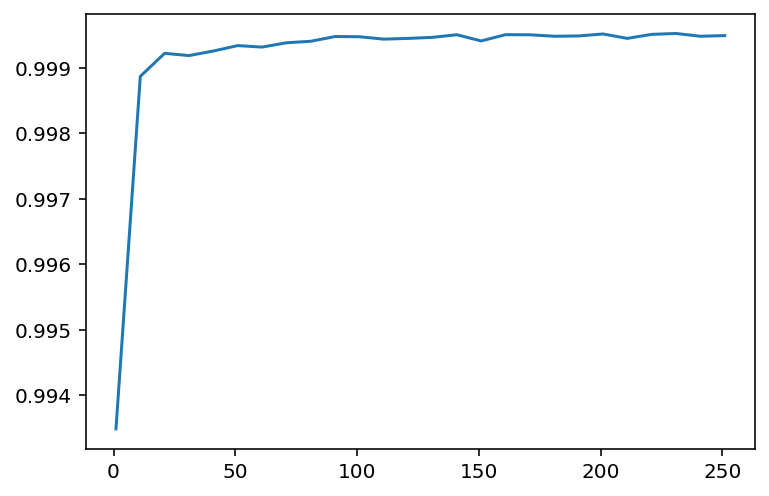

In [54]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

В целом — чем больше обученных моделей, тем лучше.

На тестовом наборе данных:

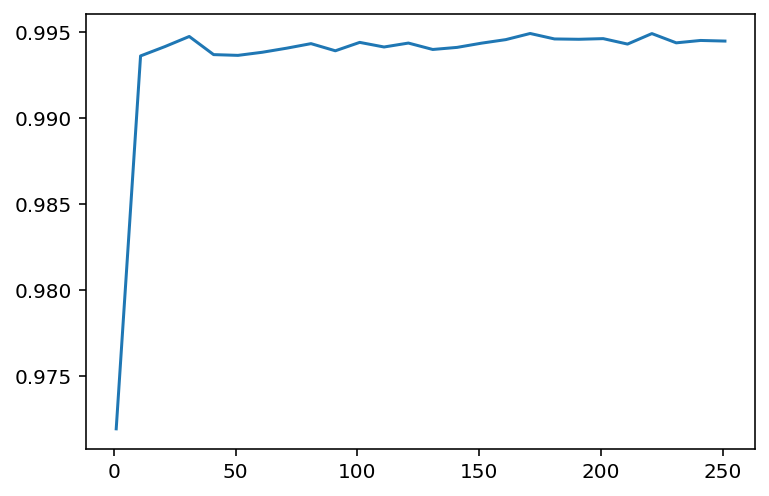

In [55]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

График не совсем ровный, но есть пик.

In [56]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 1.6065912930474338
median_absolute_error: 0.5906432748538011
r2_score: 0.996037793119825


Результат несколько лучше, чем в исходной модели.

### Градиентный бустинг

Список настраиваемых параметров тот же.

In [57]:
tuned_parameters

[{'n_estimators': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
         131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251])}]

Подбор параметра:

In [58]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=191,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Результаты при разных значения гиперпараметра на тренировочном наборе данных:

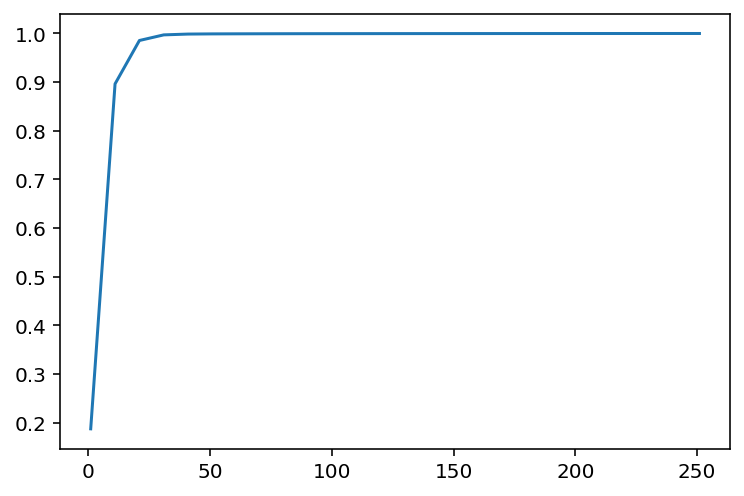

In [59]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Можно заметить, что результаты улучшаются при увеличении числа подмоделей, но скорость улучшение в определенный момент сокращается.

На тестовом наборе данных:

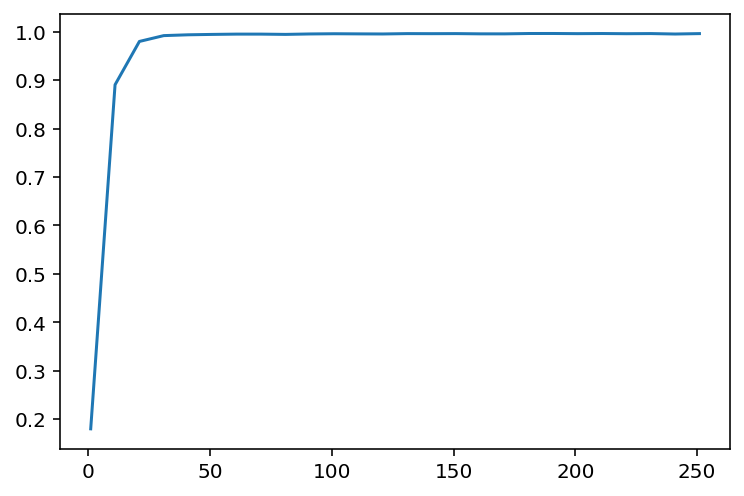

In [60]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Полученные данные подтверждают улучшение результатов при увеличении числа подмоделей.

In [61]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 2.128421259990285
median_absolute_error: 0.9142474019094298
r2_score: 0.9949449913840944


Результат лучше, чем в исходной модели.